# 质量因子回测分析

**目标**: 使用标准化的因子库进行质量因子（基于 ROE）的完整回测分析。

## 理论基础

根据《因子投资：方法与实践》第 3.6 节：
- **盈利因子**是质量因子的重要组成部分
- **ROE（净资产收益率）**代表的盈利能力与股票的未来收益呈显著正相关
- 盈利能力强的公司通常有更高的预期收益

## 因子定义

$$ROE = \frac{净利润}{净资产}$$

- 使用公告日（ann_date）对齐财务数据，避免前视偏差
- 使用 merge_asof 向后匹配，确保只使用历史可得信息

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目路径
project_root = Path('.').resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"✅ 项目根目录: {project_root}")

✅ 项目根目录: /Users/nachuanchen/Documents/Undergrad_Resources/投资学/Factor_strategy_platform


## 1. 导入质量因子模块

In [2]:
# 导入质量因子模块
from factor_library.fundamental.quality_factor import (
    calculate_quality_factor,
    run_quality_factor_backtest
)
from data_manager.data import DataManager

print("✅ 质量因子模块导入成功！")

✅ 质量因子模块导入成功！


## 2. 配置回测参数

In [3]:
# 回测参数配置
config = {
    'start_date': '2020-01-01',
    'end_date': '2023-12-31',
    'stock_codes': None,  # None 表示使用所有可用股票
    'rebalance_freq': 'weekly',  # 调仓频率：'daily', 'weekly', 'monthly'
    'transaction_cost': 0.0003,  # 0.03% 交易费用
    'long_direction': 'high',  # 'high': 做多高ROE，'low': 做多低ROE
}

print("=" * 60)
print("回测配置:")
print("=" * 60)
for key, value in config.items():
    print(f"  {key:20s}: {value}")
print("=" * 60)

回测配置:
  start_date          : 2020-01-01
  end_date            : 2023-12-31
  stock_codes         : None
  rebalance_freq      : weekly
  transaction_cost    : 0.0003
  long_direction      : high


## 3. 执行回测

调用 `run_quality_factor_backtest()` 函数执行完整的回测流程：
1. 计算质量因子（ROE）
2. 使用 BacktestEngine 进行分组回测
3. 集成 PerformanceAnalyzer 计算性能指标和 IC

In [4]:
# 执行回测
results = run_quality_factor_backtest(**config)

print("\n✅ 回测执行完成！")


开始计算质量因子（ROE）...
 清洗后数据加载成功！
  数据类型: daily
  数据量: 10,216,839 条记录，13 列
 清洗后数据加载成功！
  数据类型: daily
  数据量: 10,216,839 条记录，13 列
  过滤后: 3,420,048 条记录 (过滤了 6,796,791 条)
  过滤后: 3,420,048 条记录 (过滤了 6,796,791 条)
 清洗后数据加载成功（重复调用，已省略详细信息）
 清洗后数据加载成功（重复调用，已省略详细信息）
  过滤后: 3,420,048 条记录 (过滤了 6,796,791 条)
  过滤后: 3,420,048 条记录 (过滤了 6,796,791 条)
 清洗后数据加载成功！
  数据类型: income
  数据量: 362,154 条记录，85 列
 清洗后数据加载成功！
  数据类型: income
  数据量: 362,154 条记录，85 列
 清洗后数据加载成功！
  数据类型: balancesheet
  数据量: 356,393 条记录，152 列
 清洗后数据加载成功！
  数据类型: balancesheet
  数据量: 356,393 条记录，152 列
质量因子计算完成！共 3419078 条记录
因子值范围: [-69.3719, 25.9998]

🔧 回测引擎初始化完成
   多头方向: high
   调仓频率: weekly
   交易费用: 0.030%
   因子名称: factor
质量因子计算完成！共 3419078 条记录
因子值范围: [-69.3719, 25.9998]

🔧 回测引擎初始化完成
   多头方向: high
   调仓频率: weekly
   交易费用: 0.030%
   因子名称: factor
 清洗后数据加载成功（重复调用，已省略详细信息）
 清洗后数据加载成功（重复调用，已省略详细信息）
  过滤后: 3,419,078 条记录 (过滤了 6,797,761 条)
  过滤后: 3,419,078 条记录 (过滤了 6,797,761 条)
开始回测...

🚀 开始执行回测...
   调仓频率: weekly
   调仓次数: 204 次
开始回测...

🚀 开始执行回测...
 

## 4. 业绩分析与可视化

回测业绩指标（Long_Only 策略）
总收益率:       12.94%
年化收益率:     3.22%
年化波动率:     21.05%
夏普比率:       0.153
最大回撤:       -31.77%
调仓次数:       204

IC 分析:
  IC 均值:      -0.0003
  IC 标准差:    0.0863
  ICIR:         -0.0030
  IC>0 占比:    51.39%


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_65952/2306079016.py:62: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) SimHei.
  plt.tight_layout()
/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_65952/2306079016.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) SimHei.
  plt.tight_layout()
/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_65952/2306079016.py:62: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) SimHei.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPytho

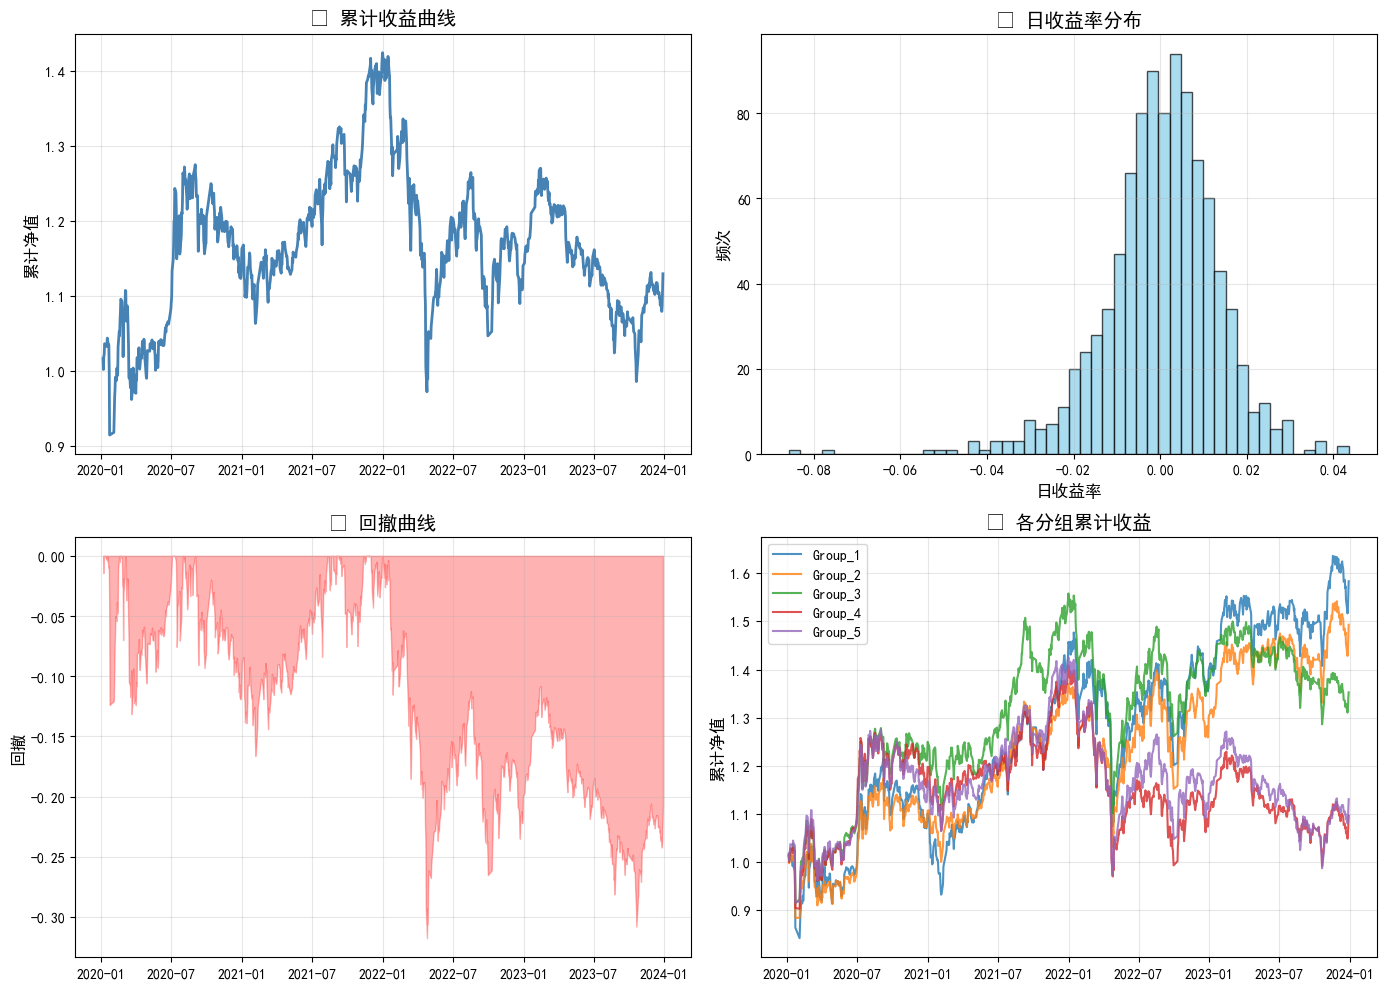


✅ 可视化完成！


In [5]:
# 显示业绩指标
metrics = results['performance_metrics']
portfolio_returns = results['portfolio_returns']

print("=" * 60)
print("回测业绩指标（Long_Only 策略）")
print("=" * 60)
print(f"总收益率:       {metrics['total_return']:.2%}")
print(f"年化收益率:     {metrics['annualized_return']:.2%}")
print(f"年化波动率:     {metrics['volatility']:.2%}")
print(f"夏普比率:       {metrics['sharpe_ratio']:.3f}")
print(f"最大回撤:       {metrics['max_drawdown']:.2%}")
print(f"调仓次数:       {metrics['rebalance_count']}")
print("=" * 60)

# IC 分析
if results['analysis_results']['ic_series'] is not None:
    ic = results['analysis_results']['ic_series']
    print(f"\nIC 分析:")
    print(f"  IC 均值:      {ic.mean():.4f}")
    print(f"  IC 标准差:    {ic.std():.4f}")
    print(f"  ICIR:         {ic.mean() / ic.std():.4f}" if ic.std() > 0 else "  ICIR: N/A")
    print(f"  IC>0 占比:    {(ic > 0).mean():.2%}")

# 可视化
long_only = portfolio_returns['Long_Only']
cum_ret = (1 + long_only).cumprod()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 累计收益曲线
axes[0, 0].plot(cum_ret.index, cum_ret.values, linewidth=2, color='steelblue')
axes[0, 0].set_title('📈 累计收益曲线', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('累计净值', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. 日收益率分布
axes[0, 1].hist(long_only, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_title('📊 日收益率分布', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('日收益率', fontsize=12)
axes[0, 1].set_ylabel('频次', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. 回撤曲线
running_max = cum_ret.cummax()
drawdown = (cum_ret - running_max) / running_max
axes[1, 0].fill_between(drawdown.index, 0, drawdown.values, color='red', alpha=0.3)
axes[1, 0].set_title('📉 回撤曲线', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('回撤', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 4. 分组收益对比
for col in portfolio_returns.columns:
    if col.startswith('Group'):
        group_cum = (1 + portfolio_returns[col]).cumprod()
        axes[1, 1].plot(group_cum.index, group_cum.values, label=col, linewidth=1.5, alpha=0.8)
axes[1, 1].set_title('📊 各分组累计收益', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('累计净值', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✅ 可视化完成！")

## 5. 结论与优化建议

### 因子有效性判断标准

1. **单调性检验**：从 Group_1 到 Group_5 的收益应呈现单调递增（long_direction='high' 时）
2. **Long-Short 收益**：多空对冲组合应有正收益，夏普比率 > 0
3. **IC 分析**：
   - IC 均值应显著为正（long_direction='high' 时）
   - ICIR > 0.5 表示因子预测能力较强
   - IC>0 占比 > 50% 表示因子稳定性较好

### 优化建议

1. **因子改进**：
   - 使用 ROE 的移动平均（如过去4个季度平均）
   - 剔除异常值（ROE < 0 或 ROE > 100%）
   - 结合其他盈利指标（ROA、毛利率等）构建综合质量因子

2. **回测参数优化**：
   - 调整调仓频率（月度调仓可能更适合基本面因子）
   - 优化分组数量（10组可能提供更好的区分度）

3. **风险控制**：
   - 设置行业中性化，避免行业集中风险
   - 添加市值、流动性等约束条件